In [81]:
# Learning Practice 5 for the University of Tulsa's QM-7063 Data Mining Course
# Prediction and Classification Methods
# # Professor: Dr. Abdulrashid, Spring 2023
# Noah L. Schrick - 1492657

%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import seaborn as sns
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score


# Problem 6.1
The file BostonHousing.csv contains information collected by the US Bureau of the Census concerning housing in the area of Boston, Massachusetts. The dataset includes information on 506 census housing tracts in the Boston area. The goal is to predict the median house price in new tracts based on information such as crime rate, pollution, and number of rooms. The dataset contains 13 predictors, and the outcome variable is the median house price (MEDV). Table 6.11 describes each of the predictors and the outcome variable.

TABLE 6.11 DESCRIPTION OF VARIABLES FOR BOSTON HOUSING EXAMPLE
CRIM    Per capita crime rate by town
ZN      Proportion of residential land zoned for lots over 25,000 ft2
INDUS   Proportion of nonretail business acres per town
CHAS    Charles River dummy variable (=1 if tract bounds river; =0 otherwise)
NOX     Nitric oxide concentration (parts per 10 million)
RM      Average number of rooms per dwelling
AGE     Proportion of owner-occupied units built prior to 1940
DIS     Weighted distances to five Boston employment centers
RAD     Index of accessibility to radial highways
TAX     Full-value property-tax rate per $10,000
PTRATIO Pupil/teacher ratio by town
LSTAT   Percentage lower status of the population
MEDV    Median value of owner-occupied homes in $100


a.
    Why should the data be partitioned into training and validation sets? What will the training set be used for? What will the validation set be used for?
b.
    Fit a multiple linear regression model to the median house price (MEDV) as a function of CRIM, CHAS, and RM. Write the equation for predicting the median house price from the predictors in the model.
c. 
    Using the estimated regression model, what median house price is predicted for a tract in the Boston area that does not bound the Charles River, has a crime rate of 0.1, and where the average number of rooms per house is 6?
d. 
    Reduce the number of predictors:
        i. Which predictors are likely to be measuring the same thing among the 13 predictors? Discuss the relationships among INDUS, NOX, and TAX.
        ii. Compute the correlation table for the 12 numerical predictors and search for highly correlated pairs. These have potential redundancy and can cause multi-collinearity. Choose which ones to remove based on this table.
        iii. Use three subset selection algorithms: backward, forward, and stepwise) to reduce the remaining predictors. Compute the validation performance for each of the three selected models. Compare RMSE, MAPE, and mean error, as well as histograms of the errors. Finally, describe the best model.

# a.
The training set is used to train and build the model. The data within this set is fed directly into the model to provide a fit.

The validation set is used to evaluate and rate the model. This data is unknown to the model since it is not fed into the training, and is not used in any other way. The model attempts to classify this unknown data, and its performance and accuracy is checked.

Partitioning the data allows us to confirm if the model is working as intended. Having a set of data used to measure the model lets us check if the fit is acceptable or not. If we were to use all of the data for training the model, and then use that same data to check performance and accuracy, we would have biased results.

In [31]:
# b.
housing_df = pd.read_csv('BostonHousing.csv')
housing_df = housing_df.drop('CAT. MEDV', axis=1)
#housing_b_df = housing_df[['MEDV', 'CRIM', 'CHAS', 'RM']]
predictors = ['CRIM', 'CHAS', 'RM']
outcome = 'MEDV'

# partition data
X = pd.get_dummies(housing_df[predictors], drop_first=True)
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
housing_lm = LinearRegression()
housing_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', housing_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': housing_lm.coef_}))

# print performance measures
regressionSummary(train_y, housing_lm.predict(train_X))

# Equation:
# MEDV = -29.19 -0.24*CRIM + 3.27*CHAS + 8.33*RM


intercept  -29.193467430606834
  Predictor  coefficient
0      CRIM    -0.240062
1      CHAS     3.266817
2        RM     8.325175

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 5.9666
            Mean Absolute Error (MAE) : 3.9668
          Mean Percentage Error (MPE) : -7.2747
Mean Absolute Percentage Error (MAPE) : 22.5927


In [22]:
# c.
housing_lm_pred = housing_lm.predict([[0, 0.1, 6]])
print(housing_lm_pred)

# Since no other samples exist for this data point, no residual error is able to be obtained.

[21.08426608]


/home/noah/.local/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<AxesSubplot: >

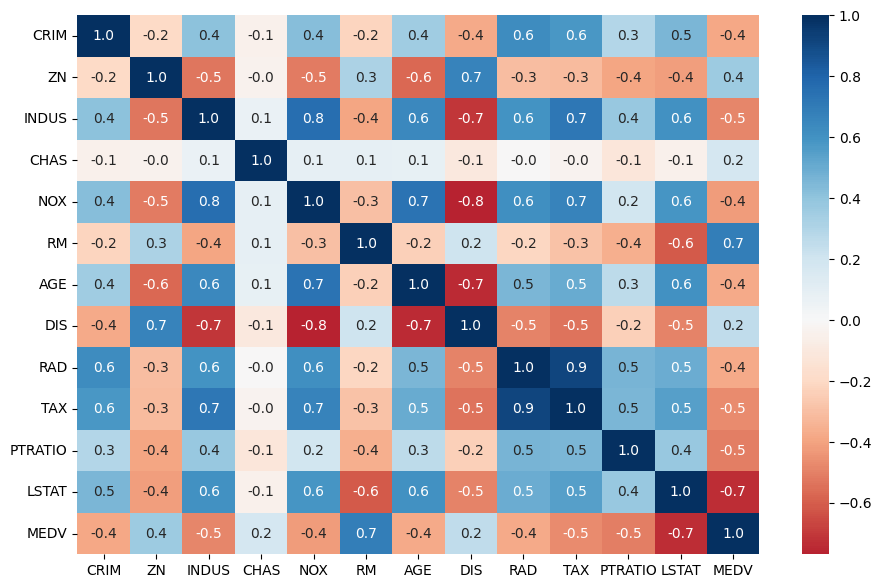

In [25]:
# d.
# i.
corr = housing_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

# Relationship between INDUS, RAD, and TAX
RAD and TAX are strongly correlated, measuring at 0.9.
INDUS and RAD are positively correlated, measuring at 0.6.
INDUS and TAX is a bit more positively correlated, measuring at 0.7.
All three of these indicate that they would be measuring the same thing.

In [26]:
# d.
# ii.
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

<AxesSubplot: >

# Highly Correlated Pairs
ZN and DIS
RAD and TAX
PTRATIO and RAD
PTRATIO and TAX

In [42]:
# d.
# iii.
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

print("Backward")
best_back_model, best_back_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)
print(best_back_variables)
regressionSummary(train_y, best_back_model.predict(train_X))
print()

Backward
Variables: CRIM, CHAS, RM
Start: score=1952.30
Step: score=1952.30, remove None
['CRIM', 'CHAS', 'RM']

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 5.9666
            Mean Absolute Error (MAE) : 3.9668
          Mean Percentage Error (MPE) : -7.2747
Mean Absolute Percentage Error (MAPE) : 22.5927



In [62]:
print("Forward")
best_forw_model, best_forw_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_forw_variables)
forw_train_X = train_X.loc[:,['RM','CRIM','CHAS']]
regressionSummary(train_y, best_forw_model.predict(forw_train_X))


Forward
Variables: CRIM, CHAS, RM
Start: score=2191.75, constant
Step: score=1989.28, add RM
Step: score=1956.79, add CRIM
Step: score=1952.30, add CHAS
Step: score=1952.30, add None
['RM', 'CRIM', 'CHAS']

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 5.9666
            Mean Absolute Error (MAE) : 3.9668
          Mean Percentage Error (MPE) : -7.2747
Mean Absolute Percentage Error (MAPE) : 22.5927


In [78]:
# d iii. continued
print("Stepwise")
best_step_model, best_step_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_step_variables)
step_train_X = train_X.loc[:,['RM','CRIM','CHAS']]
regressionSummary(train_y, best_step_model.predict(step_train_X))


Stepwise
Variables: CRIM, CHAS, RM
Start: score=2191.75, constant
Step: score=1989.28, add RM
Step: score=1956.79, add CRIM
Step: score=1952.30, add CHAS
Step: score=1952.30, add None
['RM', 'CRIM', 'CHAS']

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 5.9666
            Mean Absolute Error (MAE) : 3.9668
          Mean Percentage Error (MPE) : -7.2747
Mean Absolute Percentage Error (MAPE) : 22.5927

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 5.9666
            Mean Absolute Error (MAE) : 3.9668
          Mean Percentage Error (MPE) : -7.2747
Mean Absolute Percentage Error (MAPE) : 22.5927


In [86]:
# d iii model
print("LASSO")
lasso = Lasso(alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))
print("\n")

print("LASSO CV")
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv.alpha_)
print(lasso_cv.coef_)
print("\n")


LASSO

Regression statistics

                      Mean Error (ME) : 0.2627
       Root Mean Squared Error (RMSE) : 6.7153
            Mean Absolute Error (MAE) : 4.7355
          Mean Percentage Error (MPE) : -8.5983
Mean Absolute Percentage Error (MAPE) : 23.9824


LASSO CV

Regression statistics

                      Mean Error (ME) : 0.1124
       Root Mean Squared Error (RMSE) : 6.4186
            Mean Absolute Error (MAE) : 4.4592
          Mean Percentage Error (MPE) : -7.7091
Mean Absolute Percentage Error (MAPE) : 23.1854
Lasso-CV chosen regularization:  0.033515828458353755
[-0.24201538  2.81692528  8.25934245]


RIDGE

Regression statistics

                      Mean Error (ME) : 0.1201
       Root Mean Squared Error (RMSE) : 6.4138
            Mean Absolute Error (MAE) : 4.4590
          Mean Percentage Error (MPE) : -7.6484
Mean Absolute Percentage Error (MAPE) : 23.1724


BAYESIAN RIDGE

Regression statistics

                      Mean Error (ME) : 0.1211
       Root 

In [87]:
print("RIDGE")
ridge = Ridge(alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))
print("\n")

print("BAYESIAN RIDGE")
bayesianRidge = BayesianRidge()
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', bayesianRidge.lambda_ / bayesianRidge.alpha_)
print("\n")

RIDGE

Regression statistics

                      Mean Error (ME) : 0.1201
       Root Mean Squared Error (RMSE) : 6.4138
            Mean Absolute Error (MAE) : 4.4590
          Mean Percentage Error (MPE) : -7.6484
Mean Absolute Percentage Error (MAPE) : 23.1724


BAYESIAN RIDGE

Regression statistics

                      Mean Error (ME) : 0.1211
       Root Mean Squared Error (RMSE) : 6.4144
            Mean Absolute Error (MAE) : 4.4603
          Mean Percentage Error (MPE) : -7.6595
Mean Absolute Percentage Error (MAPE) : 23.1747
Bayesian ridge chosen regularization:  1.3591395967339095




# Best model
Bayesian Ridge: Lowest MAPE
Ridge: Lowest RMSE, lowest MAE

Ridge or Bayesian Ridge should be used. Further parameter tuning can assist in selection which of the two models to use.

# Problem 6.2
Tayko Software is a software catalog firm that sells games and educational software. It started out as a software manufacturer and then added third-party titles to its offerings. It recently revised its collection of items in a new catalog, which it mailed out to its customers. This mailing yielded 2000 purchases. Based on these data, Tayko wants to devise a model for predicting the spending amount that a purchasing customer will yield. The file Tayko.csv contains information on 2000 purchases. Table 6.12 describes the variables to be used in the problem (the Excel file contains additional variables).

TABLE 6.12 DESCRIPTION OF VARIABLES FOR TAYKO SOFTWARE EXAMPLE
FREQ                Number of transactions in the preceding year
LAST_UPDATE         Number of days since last update to customer record
WEB                 Whether customer purchased by Web order at least once
GENDER              Male or female
ADDRESS_RES         Whether it is a residential address
ADDRESS_US          Whether it is a US address
SPENDING (outcome)  Amount spent by customer in test mailing ($)

a. 
    Explore the spending amount by creating a pivot table for the categorical variables and computing the average and standard deviation of spending in each category.
b. 
    Explore the relationship between spending and each of the two continuous predictors by creating two scatterplots (Spending vs. Freq, and Spending vs. last_update_days_ago). Does there seem to be a linear relationship?
c. 
    To fit a predictive model for Spending:
    i. Partition the 2000 records into training and validation sets.
    ii. Run a multiple linear regression model for Spending vs. all six predictors. Give the estimated predictive equation.
    iii. Based on this model, what type of purchaser is most likely to spend a large amount of money?
    iv. If we used backward elimination to reduce the number of predictors, which predictor would be dropped first from the model?
    v. Show how the prediction and the prediction error are computed for the first purchase in the validation set.
    vi. Evaluate the predictive accuracy of the model by examining its performance on the validation set.
    vii. Create a histogram of the model residuals. Do they appear to follow a normal distribution? How does this affect the predictive performance of the model?

In [99]:
# a
tayko_df = pd.read_csv('Tayko.csv')
table = pd.pivot_table(tayko_df, values = ['Web order', 'Gender=male', 'Address_is_res', 'US'],
                       index='Spending',
                       aggfunc=['mean', 'std'])

print(table)


                   mean                                            std  \
         Address_is_res Gender=male        US Web order Address_is_res   
Spending                                                                 
0              0.219219    0.535536  0.815816  0.307307       0.413925   
1              0.000000    0.000000  1.000000  1.000000            NaN   
3              0.666667    0.333333  0.666667  0.333333       0.577350   
4              0.500000    0.000000  1.000000  0.500000       0.707107   
6              0.666667    0.666667  1.000000  0.666667       0.577350   
...                 ...         ...       ...       ...            ...   
1416           0.000000    1.000000  1.000000  0.000000            NaN   
1441           0.000000    1.000000  0.000000  0.000000            NaN   
1443           0.000000    0.000000  1.000000  1.000000            NaN   
1446           0.000000    1.000000  1.000000  0.000000            NaN   
1500           0.000000    1.000000  1

<AxesSubplot: xlabel='Spending', ylabel='last_update_days_ago'>

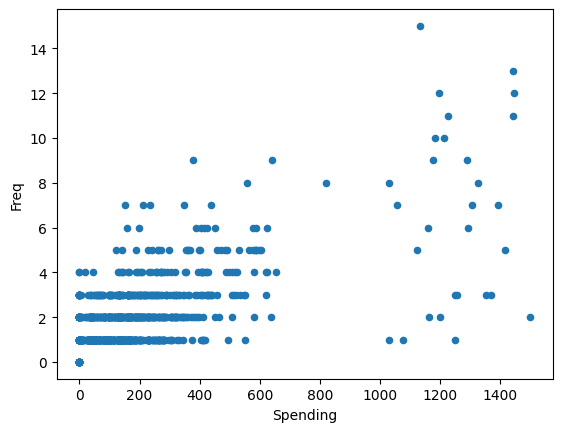

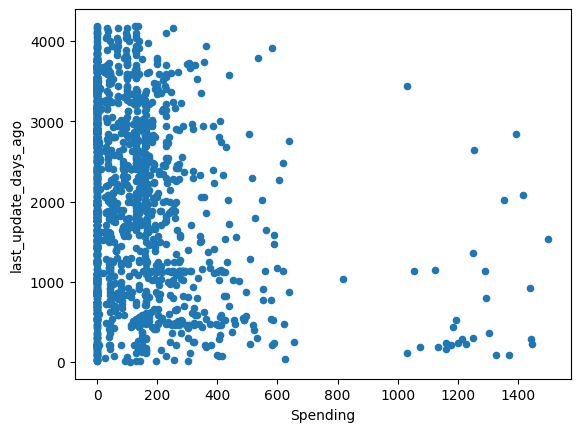

In [105]:
# b. 
## Scatter plot with pandas
tayko_df.plot.scatter(x='Spending', y='Freq', legend=False)
tayko_df.plot.scatter(x='Spending', y='last_update_days_ago', legend=False)


# Linear? 
There does not appear to be a linear relationship between spending and last update days ago.
An argument could be made for Frequency and Spending as spending gets larger, but both scatter plots do not seem to indicate a linear relationship. The linear fit for frequency and spending would have a low R squared value.

In [114]:
# c. i
predictors = ['US','Freq', 'last_update_days_ago', 'Web order', 'Gender=male', 'Address_is_res']

outcome = 'Spending'
X = pd.get_dummies(tayko_df[predictors], drop_first=True)
y = tayko_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


In [115]:
# c. ii
tayko_lm = LinearRegression()
tayko_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', tayko_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': tayko_lm.coef_}))

# print performance measures
regressionSummary(valid_y, tayko_lm.predict(valid_X))

intercept  10.17629741458822
              Predictor  coefficient
0                    US    -4.620293
1                  Freq    91.274450
2  last_update_days_ago    -0.010374
3             Web order    18.628731
4           Gender=male    -9.111366
5        Address_is_res   -75.815354

Regression statistics

               Mean Error (ME) : 7.1933
Root Mean Squared Error (RMSE) : 136.7397
     Mean Absolute Error (MAE) : 83.6010


# iii Based on this model, what type of purchaser is most likely to spend a large amount of money?
Women outside the US that do not have a residential address, that place web orders, and made many transactions the previous year.

In [117]:
#iv. If we used backward elimination to reduce the number
# of predictors, which predictor would be dropped first 
# from the model?

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

print("Backward")
best_back_model, best_back_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)
print(best_back_variables)

# 'US' dropped first

Backward
Variables: US, Freq, last_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=15028.53
Step: score=15026.76, remove US
Step: score=15026.38, remove Gender=male
Step: score=15026.38, remove None
['Freq', 'last_update_days_ago', 'Web order', 'Address_is_res']



# v. Show how the prediction and the prediction error are computed for the first purchase in the validation set.

After the model is trained, we have the regression coefficients.
Using these, we can multiply them with the new predictor values.
Using the sample of the first purchase, each predictor is multiplied by the coefficients to compute the prediction.

The error is obtained by comparing the predicted value to the actual value.

In [119]:
#vi. Evaluate the predictive accuracy of the model by
# examining its performance on the validation set.

tayko_lm_pred = tayko_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': tayko_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - tayko_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, tayko_lm_pred)

       Predicted  Actual     Residual
674    89.214915       0   -89.214915
1699  202.231362     184   -18.231362
1282   49.159303       0   -49.159303
1315  824.841659    1289   464.158341
1210    0.121196       0    -0.121196
1636   86.766675       0   -86.766675
613    58.018614       0   -58.018614
447   247.428569    1255  1007.571431
1131   67.036615       0   -67.036615
808    67.825031       0   -67.825031
1496   -7.098168       0     7.098168
1468  194.814024     411   216.185976
1682  -13.480101       0    13.480101
1149  -32.457046       0    32.457046
442    61.247979       0   -61.247979
1813    4.497885     173   168.502115
654   -46.046854       0    46.046854
1264  -32.315195       0    32.315195
858    80.219048       0   -80.219048
1482   51.783900       0   -51.783900

Regression statistics

               Mean Error (ME) : 7.1933
Root Mean Squared Error (RMSE) : 136.7397
     Mean Absolute Error (MAE) : 83.6010


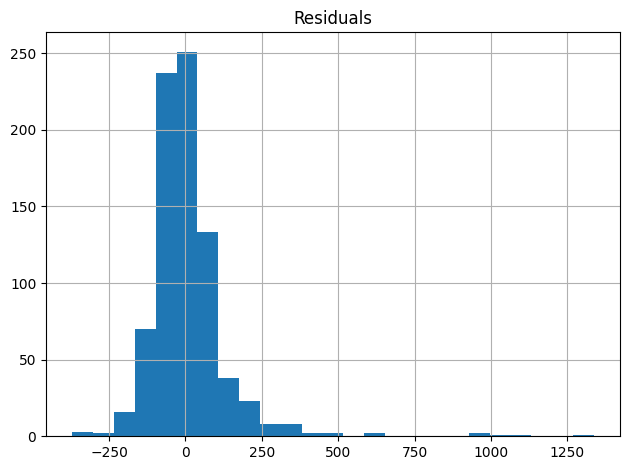

In [121]:
#vii. Create a histogram of the model residuals. 
# Do they appear to follow a normal distribution? 
# How does this affect the predictive performance of the model?

tayko_lm_pred = tayko_lm.predict(valid_X)
all_residuals = valid_y - tayko_lm_pred

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()